In [88]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import hashlib
import re
from sklearn.model_selection import GridSearchCV

In [8]:
import matplotlib.pyplot as plt

In [9]:
import seaborn as sns
sns.set(color_codes=True)

In [10]:
np.log(0.8)

-0.22314355131420971

In [48]:
def runStackingGaussian(X,y):
    from sklearn.model_selection import StratifiedKFold
    
    skf = StratifiedKFold(n_splits = 5,shuffle=True, random_state=22)
    ii = 0
    for train_index,test_index in skf.split(X,y):
        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test = y[train_index],y[test_index]
        print 'running Random Forest'
        pred_rf = runRF(X_train,y_train,X_test)
        print 'RF log loss = {}'.format(log_loss(y_test, pred_rf))
        print 'running Xgboost'
        pred_xgb,_ = runXGB(X_train,y_train,X_test)
        print 'XGB log loss = {}'.format(log_loss(y_test, pred_xgb))
            
        import pdb;pdb.set_trace()
        y_rf0 = pred_rf[y_test==0,:2]
        y_rf1 = pred_rf[y_test==1,:2]
        y_rf2 = pred_rf[y_test==2,:2]
        y_xgb0 = pred_xgb[y_test==0,:2]
        y_xgb1 = pred_xgb[y_test==1,:2]
        y_xgb2 = pred_xgb[y_test==2,:2]
        mat0 = np.hstack([y_rf0,y_xgb0])
        mat1 = np.hstack([y_rf1,y_xgb1])
        mat2 = np.hstack([y_rf2,y_xgb2])
        
        if ii == 0:                        
            cov0 = np.cov(mat0.T)
            cov1 = np.cov(mat1.T)
            cov2 = np.cov(mat2.T)
            sigma0 = np.linalg.inv(cov0)
            sigma1 = np.linalg.inv(cov1)
            sigma2 = np.linalg.inv(cov2)
            
            mu0 = np.mean(mat0,axis=0)
            mu1 = np.mean(mat1,axis=0)
            mu2 = np.mean(mat2,axis=0)
            
            sqrt_det0 = np.sqrt(np.linalg.det(sigma0))
            sqrt_det1 = np.sqrt(np.linalg.det(sigma1))
            sqrt_det2 = np.sqrt(np.linalg.det(sigma2))
            
            lambda0 = sum(y_test==0)/float(len(y_test))
            lambda1 = sum(y_test==1)/float(len(y_test))
            lambda2 = 1-lambda0-lambda1
        else:
            
            mat = np.hstack([pred_rf[:,:2],pred_xgb[:,:2]])
            mat0 = mat - mu0
            mat1 = mat - mu1
            mat2 = mat - mu2
            a0 = np.exp(-np.sum(np.dot(mat0,sigma0)*mat0,axis=1)/2)*sqrt_det0 *lambda0
            a1 = np.exp(-np.sum(np.dot(mat1,sigma1)*mat1,axis=1)/2)*sqrt_det1 *lambda1
            a2 = np.exp(-np.sum(np.dot(mat2,sigma2)*mat2,axis=1)/2)*sqrt_det2 *lambda2
            new_pred = np.hstack([a0.reshape((len(a0),1)),a1.reshape((len(a1),1)),a2.reshape((len(a2),1))])
            new_pred = new_pred/np.kron(np.sum(new_pred,axis=1).reshape(new_pred.shape[0],1),np.ones((1,3)))
            
            print 'Stacking log loss={}'.format(log_loss(y_test,new_pred))
        ii += 1
            
            
            
    

In [ ]:
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)


In [49]:
def plot_hist(y,pred):
    #import pdb;pdb.set_trace()
    y0 = pred[y==0,2]
    y1 = pred[y==1,2]
    y2 = pred[y==2,2]
    plt.figure()
    
    sns.kdeplot(y0,label="High")
    sns.kdeplot(y1,label="Medium")
    sns.kdeplot(y2,label="Low")
    
    plt.legend()
    plt.show()

In [50]:
def runExTree(train_X,train_y,test_X,test_y=None,criterion='gini',feature_names=None,seed_val=0):    
    from sklearn.ensemble import ExtraTreesClassifier
    params = {'n_estimators':[100,200,400]}
    rf = ExtraTreesClassifier(n_jobs=-1,criterion=criterion)
    
    clf = GridSearchCV(rf, params)
    clf.fit(train_X,train_y)
    pred_test_y = clf.predict_proba(test_X)
    
    #plot_hist(test_y,pred_test_y)
    return pred_test_y

In [51]:
def runRF(train_X, train_y, test_X, test_y=None, criterion='gini',feature_names=None, seed_val=0):    
    from sklearn.ensemble import RandomForestClassifier
    params = {'n_estimators':[100,200,400]}
    rf = RandomForestClassifier(n_jobs=-1,criterion=criterion)
    
    clf = GridSearchCV(rf, params)
    clf.fit(train_X,train_y)
    pred_test_y = clf.predict_proba(test_X)
    
    #plot_hist(test_y,pred_test_y)
    return pred_test_y

In [84]:
def runGBM(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):    
    from sklearn.ensemble import GradientBoostingClassifier
    params = {'learning_rate':[0.05,0.01], 'n_estimators':[500,800], 
              'subsample':[0.5],'max_depth':[5,7]}
    rf = GradientBoostingClassifier()
    
    clf = GridSearchCV(rf, params,n_jobs=-1)
    clf.fit(train_X,train_y)
    pred_test_y = clf.predict_proba(test_X)
    
    #plot_hist(test_y,pred_test_y)
    return pred_test_y

In [65]:
def runXGB(train_X, train_y, test_X=None, test_y=None, feature_names=None, seed_val=0, num_rounds=2000):
    param = {}
    param['objective'] = 'multi:softprob'
    #param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    
    def custom_rates(boosting_round, num_boost_round):
        total_round = max(boosting_round,num_boost_round)
        curr_round = min(boosting_round,num_boost_round)
        
        if curr_round<50:
            return 0.1
        elif curr_round<200:
            #print 'learning rate 0.01'
            return 0.05
        elif curr_round<total_round/5:
            return 0.01
        elif curr_round<total_round/3:
            return 0.005
        else:
            return 0.0001

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=30,verbose_eval=False, 
                          callbacks = [xgb.callback.reset_learning_rate(custom_rates)])
    else:
        
        model = xgb.train(plst, xgtrain, num_rounds,verbose_eval=False,
                          callbacks = [xgb.callback.reset_learning_rate(custom_rates)])
    pred_test_y = None
    if test_X is not None:
        xgtest = xgb.DMatrix(test_X)
        pred_test_y = model.predict(xgtest)
    
    #plot_hist(test_y,pred_test_y)
    return pred_test_y, model

In [17]:
tmp

array([[ 0.39620198,  0.59327894,  0.4047958 ,  0.60122197],
       [ 0.69109454,  0.08848126,  0.02365031,  0.14013492],
       [ 0.36366012,  0.12580145,  0.89277637,  0.85126566]])

In [18]:
tmp-np.array([1,1,1,1])

array([[-0.60379802, -0.40672106, -0.5952042 , -0.39877803],
       [-0.30890546, -0.91151874, -0.97634969, -0.85986508],
       [-0.63633988, -0.87419855, -0.10722363, -0.14873434]])

In [19]:
def runXGB_sklearn(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=5000):

    clf = XGBClassifier(n_estimators=num_rounds,
                            objective='multi:softprob',
                            learning_rate=0.01,
                            max_depth=6,
                            min_child_weight=1,
                            subsample=.7,
                            colsample_bytree=.7,
                            colsample_bylevel=.5,
                            gamma=0.005,
                            scale_pos_weight=1,
                            base_score=.5,
                            #reg_lambda=0,
                            #reg_alpha=0,
                            #missing=0,
                            seed=seed_val)
    
    if test_y is not None:
        #xgtest = xgb.DMatrix(test_X, label=test_y)
        #watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        #model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20,verbose_eval=False)
        clf.fit(train_X, train_y,eval_set=[(train_X, train_y), (test_X, test_y)],verbose=True,eval_metric='mlogloss',
            early_stopping_rounds=50)
    else:        
        clf.fit(train_X, train_y,verbose=False)
    pred_test_y = clf.predict_proba(test_X)
    return pred_test_y, clf

       
        # Train the model
       

In [90]:
def runXGB_sklearn_rank(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=2000):

    clf = XGBRegressor(n_estimators=num_rounds,
                            objective='rank:pairwise',
                            learning_rate=0.01,
                            max_depth=6,
                            min_child_weight=1,
                            subsample=.7,
                            colsample_bytree=.7,
                            colsample_bylevel=.5,
                            gamma=0.005,
                            scale_pos_weight=1,
                            base_score=.5,
                            #reg_lambda=0,
                            #reg_alpha=0,
                            #missing=0,
                            seed=seed_val)
    
    if test_y is not None:
        #xgtest = xgb.DMatrix(test_X, label=test_y)
        #watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        #model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20,verbose_eval=False)
        clf.fit(train_X, train_y,eval_set=[(train_X, train_y), (test_X, test_y)],verbose=True,
            early_stopping_rounds=50)
    else:        
        clf.fit(train_X, train_y,verbose=False)
    pred_test_y = clf.predict_proba(test_X)
    return pred_test_y, clf

       
        # Train the model
       

In [20]:
def tfidf_fea(traindf,testdf,col='description',max_features=200):
    df1 = traindf.copy()
    df2 = testdf.copy()
    df = df1.append(df2)
    
    tfidf = TfidfVectorizer(stop_words='english',max_features=max_features)
    tfidf.fit(df[col])
    tr_sparse = tfidf.transform(df1[col])
    te_sparse = tfidf.transform(df2[col])
    return tr_sparse,te_sparse


In [21]:
def text_fea(df1_,df2_,nTop=100,combine=False):
    ''' df1_ is training set
        df2_ is test set
    '''
    from collections import defaultdict
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    df['features'] = df['features'].map(lambda x:[tt.lower() for tt in x])
    df['description'] = df['description'].map(lambda x:x.lower())
    
    all_fea = defaultdict(int)
    for _,row in df.iterrows():
        for xx in row['features']:
            all_fea[xx] += 1
    sorted_fea = sorted(all_fea.iteritems(),key=lambda (k,v): v,reverse=True)
    
    combined_fea = {'laundry in unit':['laundry in unit','in-unit washer/dryer','washer & dryer',
                                        'washer/dryer','washer/dryer in unit'],
                   'laundry in building':['laundry in building','laundry room',
                                           'washer/dryer in building','on-site laundry'],
                   'gym/fitness':['gym/fitness','fitness center','gym','gym in building'],
                   'pre-war':['pre-war','prewar'],
                    'live-in superintendent':['live-in superintendent','live-in super','live in super']
                   #'garage':['garage','parking']
                   }
    
    fea_list = set([v[0] for v in sorted_fea[:nTop]])
    for k,v in combined_fea.iteritems():
        fea_list = fea_list.union(set(v))
    for fea in fea_list:
        df[fea] = 0
    #import pdb;pdb.set_trace()
    for inx,row in df.iterrows():
        notlist = []
        if len(row['features']) == 0:
            continue
        for ff in row['features']:
            if ff in fea_list:
                df.set_value(inx,ff,1)
            else:
                notlist.append(ff)
        df.set_value(inx,'description',row['description'] + ' '.join(notlist))
    print 'fea_list length is {}'.format(len(fea_list))
    fea_list = set(fea_list)
    if combine:        
        for k,v in combined_fea.iteritems():
            df[k] = df[v[0]]
            #print k,v
            for ii in range(1,len(v)):
                df[k] = df[k] + df[v[ii]]
                del df[v[ii]]
                fea_list.remove(v[ii])
    fea_list = list(fea_list)
    print 'fea_list length is {}'.format(len(fea_list))
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    return df1,df2,fea_list

In [22]:
def RandomLabelEncoding(df,column):
    # assuming input are already hashed
    le = preprocessing.LabelEncoder()
    maxlen = df[column].map(len).max()
    df[column] = df[column].map(lambda x:str(x).zfill(maxlen))
    fea_list = []
    for ii in range(maxlen):
        fea_name = column + str(ii+1)
        fea_list.append(fea_name)
        df[fea_name] = df[column].map(lambda x:x[ii])
        df[fea_name] = le.fit_transform(df[fea_name])
    return df,fea_list

def category_proc(df1_,df2_,col_list = ['manager_id','building_id']):
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    all_list = []
    for xx in col_list:
        df,list1 = RandomLabelEncoding(df,xx)
        all_list = all_list + list1
        #df,list2 = RandomLabelEncoding(df,'building_id')
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    
    return df1,df2,all_list

def simple_category_proc(df1_,df2_):
    df1 = df1_.copy()
    df2 = df2_.copy()
    
    categorical = ["manager_id", "building_id"]
    ffl = []
    for f in categorical:
        if df1[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df1[f].values) + list(df2[f].values))
            df1[f] = lbl.transform(list(df1[f].values))
            df2[f] = lbl.transform(list(df2[f].values))
            ffl.append(f)
    
    return df1,df2,ffl

In [23]:
def normalize_num(x):
    if x[-1]=='1':
        return x+'st'
    elif x[-1]=='2':
        return x+'nd'
    elif x[-1]=='3':
        return x+'rd'
    else:
        return x+'th'

def normalize_street(x):
    street_name_mapping = {'st.':'street','st':'street','st,':'street','st..':'street','street,':'street',
                       'ave':'avenue','ave.':'avenue','ave,':'avenue','avenue,':'avenue','pl':'place',
                       'blvd':'boulevard','pkwy':'parkway','dr':'drive','rd.':'road','rd,':'road','rd':'road',
                       'ln':'lane',
                       'e':'east','e.':'east','w.':'west','w':'west','west,':'west','s':'south','&':'and',
                       'second':'2nd','first':'1st','third':'3rd','fourth':'4th','fifth':'5th',
                       'sixth':'6th','seventh':'7th','eighth':'8th','ninth':'9th','tenth':'10th',                       
                       #'1':'1st','2':'2nd','43':'43rd','37':'37th','34':'34th',
                      }
    xlist = x.lower().strip(' .,').split()
    output = []
    for tt in xlist:
        tmp = tt.strip(',.*')
        if len(tmp)>0:
            if tmp in street_name_mapping:
                tmp = street_name_mapping[tmp]
            elif tmp.isdigit():
                tmp = normalize_num(tmp)
            else:
                pass
            output.append(tmp)
    return ' '.join(output).strip()      

def rem_streetname_xy(x,y):
    '''remove x from y
    '''
    pos = y.find(x)
    if pos>0:
        tmp = y.replace(x,'').strip(' ,.')
        tmp = tmp.split(' ')[0].strip(',. #')
        if '-' in tmp:        
            tmp = tmp.split('-')[0].strip(', .#')
        try:
            a = int(tmp)
            return a
        except ValueError:
            #print tmp
            return None
    else:
        return None   

def rem_streetname(row):
    '''remove x from y
    '''
    x = row['display_address']
    y = row['street_address']
    #print x,y
    return rem_streetname_xy(x,y)

def coordinate_rotation_fn(df_,angle,center_point=(-73.9787,40.7587)):
    # Use rockefeller center as the center point
    df = df_.copy()
    df['longitude'] = df['longitude'] - center_point[0]
    df['latitude'] = df['latitude'] - center_point[1]
    aa = np.dot(np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]]),np.array([df['longitude'],
                df['latitude']]))
    df['longitude'] = aa[0]
    df['latitude'] = aa[1]
    return df

def coordinate_rotation(traindf_,testdf_):
    from sklearn.linear_model import LinearRegression
    traindf = traindf_.copy()
    testdf = testdf_.copy()
    rockefeller = (-73.9787,40.7587)
    west, south, east, north = -74.02, 40.64, -73.85, 40.86
    tmpdf = traindf[(traindf['longitude']>west)&(traindf['longitude']<east)
                        &(traindf['latitude']<north)&(traindf['latitude']>south)]
    
    x = tmpdf[tmpdf['display_address']=='west 34th street']['longitude']
    y = tmpdf[tmpdf['display_address']=='west 34th street']['latitude']
    x = x[x<-73.985]-rockefeller[0]
    y = np.array(y[x.index])-rockefeller[1]
    x = np.array(x)
    
    lr = LinearRegression()
    lr.fit(x.reshape(-1,1),y)
    angle = np.arctan(np.abs(lr.coef_[0]))
    traindf = coordinate_rotation_fn(traindf,angle,rockefeller)
    testdf = coordinate_rotation_fn(testdf,angle,rockefeller)
    return traindf,testdf

def get_address_num_simple(x):
    if len(x)==0:
        return -1
    
    x1 = x.strip().split()[0]
    if x1.isdigit():
        return float(x1)
    return -1

def street_serial(df1_,df2_):
    '''
    extract street or avenue number from displayed address. The displayed address itself will be hased to be 
    a separate feature.
    
    For those displayed address like 'w 3rd street and 5th avenue', all three fields will have values. 
    For a majority cases, one of the (west_east, street) or (avenue) will be null (0)
    '''
    
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    ave_mapping = {'lexington avenue': '3.5 avenue',
                  'park avenue':'4 avenue',
                  'madison avenue':'4.5 avenue',
                  'central park west':'8 avenue',
                  'columbus avenue':'9 avenue',
                  'amsterdam avenue':'10 avenue',
                  'west end avenue':'11 avenue'
                  }
    addr_adjust = {'central park west':5000,
                  'columbus avenue':5000,
                  'amsterdam avenue':5000,
                  'west end avenue':5000        
                }       
    
    df['west_east'] = 0 #west = -1,east = 1, null=0
    df['street_num'] = 0 # street number e.g. 12nd street will be 12, if not on a street, empty
    df['ave_num'] = 0 #avenue number, if not on avenue, empty
    df['addr_num_adjust'] = 0 # for several avenues 
    
    #import pdb;pdb.set_trace()
    
    for inx,row in df.iterrows():
        addr_str = ''
        addr_ave = ''
        
        if ' and ' in row['display_address']:
            ss = row['display_address'].split(' and ')
            if len(ss)>2:
                continue
            if ' street' in ss[0] and ' avenue' in ss[1]:
                addr_str = ss[0].strip()
                addr_ave = ss[1].strip()
            elif ' street' in ss[1] and ' avenue' in ss[0]:
                addr_str = ss[1].strip()
                addr_str = ss[0].strip()
            else:
                continue
        else:            
            if ' street' in row['display_address']:
                addr_str = row['display_address'].strip()
            if ' avenue' in row['display_address']:
                addr_ave = row['display_address'].strip()
        
        if len(addr_str)>0:
            num = re.sub('\D+','',row['display_address'])
            if len(num)>0:
                fields = addr_str.split()
                west_east = 0
                ii=0
                while ii < len(fields):
                    if fields[ii].strip() == 'west':
                        west_east = -1
                        break
                    elif fields[ii].strip() == 'east':
                        west_east = 1
                        break
                    ii += 1
                if ii<len(fields)-2:                    
                    df.set_value(inx,'west_east',west_east)   
                    try:
                        df.set_value(inx,'street_num',float(re.sub('\D+','',fields[ii+1])))
                    except ValueError:
                        pass
                        #print addr_str
                        #return None,None
        if len(addr_ave)>0:
            adjust = 0
            if addr_ave in addr_adjust:
                adjust = addr_adjust[addr_ave]
            if addr_ave in ave_mapping:
                addr_ave = ave_mapping[addr_ave]
            try:
                df.set_value(inx,'ave_num',float(re.sub('\D+','',addr_ave.split()[0])))
            except ValueError:
                #print addr_ave
                pass
            df.set_value(inx,'addr_num_adjust',adjust)
    df['address_num'] = df['address_num'] + df['addr_num_adjust']    
    del df['addr_num_adjust']
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    
    fea_list = ['west_east','street_num','ave_num']
    return df1,df2,fea_list
    

def multiple_hashing(df1_,df2_,col_name,nHash=3):
    from sklearn.preprocessing import LabelEncoder
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    fea_list = []
    
    all_hasher = [hashlib.sha1,hashlib.sha224, hashlib.sha256, hashlib.sha384, hashlib.sha512,hashlib.md5]
    if nHash>len(all_hasher):
        nHash = len(all_hasher)
    for ii in range(nHash):
        cname = col_name+ str(ii+1)
        df[cname] = df[col_name].map(lambda x:all_hasher[ii](x.encode("ascii","ignore")).hexdigest())
        fea_list.append(cname)
        le = LabelEncoder()
        df[cname] = le.fit_transform(df[cname])
        
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    
    return df1,df2,fea_list

def simple_hashing(df1_,df2_,col_name):
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1[col_name+'_hash'] = df1[col_name].map(lambda x:hashlib.md5(x.encode("ascii","ignore")).hexdigest())
    df2[col_name+'_hash'] = df2[col_name].map(lambda x:hashlib.md5(x.encode("ascii","ignore")).hexdigest())
    return df1,df2,[col_name+'_hash']

def address_proc():
    data_path = "../input/"
    train_file = data_path + "train.json"
    test_file = data_path + "test.json"
    train_df = pd.read_json(train_file)
    test_df = pd.read_json(test_file)
    original_col = train_df.columns
    
    train_df['address_num'] = train_df['street_address'].map(get_address_num_simple)
    test_df['address_num'] = test_df['street_address'].map(get_address_num_simple)
    train_df['display_address'] = train_df['display_address'].map(lambda x:normalize_street(x))
    test_df['display_address'] = test_df['display_address'].map(lambda x:normalize_street(x))
    train_df['street_address'] = train_df['street_address'].map(lambda x:normalize_street(x))
    test_df['street_address'] = test_df['street_address'].map(lambda x:normalize_street(x))
    
    flist = ['address_num']
    train_df,test_df,ff1 = street_serial(train_df,test_df)
    #train_df,test_df,ff2 = multiple_hashing(train_df,test_df,'display_address')
    train_df,test_df,ff2 = simple_hashing(train_df,test_df,'street_address')
    
    flist = flist + ff1 + ff2
    return train_df,test_df,flist

In [24]:
def median_price_address(df1_,df2_):
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    gp = df.groupby('street_address')['price'].median()
    gp.name = 'median_price_street'
    gp = gp.reset_index()
    df = pd.merge(df,gp,how='left',on='street_address')
    
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    
    return df1,df2,['median_price_street']

def median_price_lat_long(df1_,df2_,step_size=0.01):
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    west, south, east, north = -74.02, 40.64, -73.85, 40.86
    df['long_grid'] = df['longitude'].map(lambda x: (x-west)/step_size)
    df['lat_grid'] = df['latitude'].map(lambda x:(x-south)/step_size)
    
    def median_by_apt_type(df_,apt_type):
        #apt_type = (bedrooms,bathrooms)
        df = df_.copy()
        tmpdf = df[(df['bedrooms']==apt_type[0])&(df['bathrooms']==apt_type[1])]
        gp = tmpdf.groupby(['long_grid','lat_grid'])['price'].median()
        col_name = 'median_price_' + str(apt_type[0])+'_'+str(apt_type[1])
        gp.name = col_name
        gp = gp.reset_index()
        df = pd.merge(df,gp,how='left',on=['long_grid','lat_grid'])
        df[col_name] = df[col_name].fillna(0)
        return df,[col_name]
    apt_type_list=[(0,1),(1,1),(2,1),(3,1),(3,2)]
    col_list = []
    #import pdb;pdb.set_trace()
    for xx in apt_type_list:
        df,col_name = median_by_apt_type(df,xx)
        col_list += col_name
    
    del df['long_grid']
    del df['lat_grid']
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    return df1,df2,col_list
    

In [25]:
use_median_price = False

In [26]:
train_df,test_df,addr_fea_list = address_proc()

In [27]:
train_df,test_df,txt_fea_list = text_fea(train_df,test_df,combine=True)

fea_list length is 104
fea_list length is 91


In [28]:
#train_df,test_df,category_fea_list = category_proc(train_df,test_df,['manager_id','building_id','street_address_hash'])
train_df,test_df,category_fea_list = category_proc(train_df,test_df,['manager_id','building_id'])
#train_df,test_df,category_fea_list = simple_category_proc(train_df,test_df,['manager_id','building_id','display_address_hash'])

In [29]:
if use_median_price:
    train_df,test_df,median_list = median_price_lat_long(train_df,test_df,step_size=0.005)

In [30]:
# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

test_df['days'] = test_df['created']-pd.to_datetime('2016-04-01')
train_df['days'] = train_df['created'] - pd.to_datetime('2016-04-01')

test_df['days'] = test_df['days']/np.timedelta64(1, 'D')
train_df['days'] = train_df['days']/np.timedelta64(1,'D')

# Let us extract some features like year, month, day, hour from date columns #
#train_df["created_year"] = train_df["created"].dt.year
#test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

In [31]:
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

In [32]:
#features_to_use  = addr_fea_list + category_fea_list + txt_fea_list 
#features_to_use  = ['address_num','west_east', 'street_num', 'ave_num']+category_fea_list + txt_fea_list + ["bathrooms", "bedrooms", "latitude", "longitude", "price","days","num_photos"]#,"created_month"]
#features_to_use  = median_list + ['address_num','west_east', 'street_num', 'ave_num'] + category_fea_list + txt_fea_list + ["num_features","num_description_words",'listing_id',"bathrooms", "bedrooms", "latitude", "longitude", "price","days","num_photos","created_year", "created_month", "created_day", "created_hour"]
features_to_use  = ['address_num','west_east', 'street_num', 'ave_num'] + category_fea_list + txt_fea_list + ["num_features","num_description_words",'listing_id',"bathrooms", "bedrooms", "latitude", "longitude", "price","days","num_photos", "created_month", "created_day", "created_hour"]

In [33]:
train_X = train_df[features_to_use].as_matrix()
test_X = test_df[features_to_use].as_matrix()

In [34]:
target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

((49352, 172), (74659, 172))


In [85]:
runStackingKDE(train_X,train_y)

running GBM (sklearn)


KeyboardInterrupt: 

In [82]:
def runStackingKDE(X,y):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.neighbors import KernelDensity
    
    skf = StratifiedKFold(n_splits = 5,shuffle=True, random_state=22)
    ii = 0
    for train_index,test_index in skf.split(X,y):
        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test = y[train_index],y[test_index]
        print 'running GBM (sklearn)'
        #pred_rf = runRF(X_train,y_train,X_test)
        pred_rf = runGBM(X_train,y_train,X_test)
        print 'RF log loss = {}'.format(log_loss(y_test, pred_rf))
        print 'running Xgboost'
        pred_xgb,_ = runXGB(X_train,y_train,X_test)
        print 'XGB log loss = {}'.format(log_loss(y_test, pred_xgb))
            
        #import pdb;pdb.set_trace()
        y_rf0 = pred_rf[y_test==0,:2]
        y_rf1 = pred_rf[y_test==1,:2]
        y_rf2 = pred_rf[y_test==2,:2]
        y_xgb0 = pred_xgb[y_test==0,:2]
        y_xgb1 = pred_xgb[y_test==1,:2]
        y_xgb2 = pred_xgb[y_test==2,:2]
        mat0 = np.hstack([y_rf0,y_xgb0])
        mat1 = np.hstack([y_rf1,y_xgb1])
        mat2 = np.hstack([y_rf2,y_xgb2])
        
        if ii == 0:                        
            params = {'bandwidth': np.logspace(-2, -1, 10)}
            grid0 = GridSearchCV(KernelDensity(), params)
            grid1 = GridSearchCV(KernelDensity(), params)
            grid2 = GridSearchCV(KernelDensity(), params)
            grid0.fit(mat0)
            grid1.fit(mat1)
            grid2.fit(mat2)
            
            lambda0 = sum(y_test==0)/float(len(y_test))
            lambda1 = sum(y_test==1)/float(len(y_test))
            lambda2 = 1-lambda0-lambda1
        else:
            
            mat = np.hstack([pred_rf[:,:2],pred_xgb[:,:2]])
            
            a0 = np.exp(grid0.best_estimator_.score_samples(mat))
            a1 = np.exp(grid1.best_estimator_.score_samples(mat))
            a2 = np.exp(grid2.best_estimator_.score_samples(mat))
            new_pred = np.hstack([a0.reshape((len(a0),1)),a1.reshape((len(a1),1)),a2.reshape((len(a2),1))])
            new_pred = new_pred/np.kron(np.sum(new_pred,axis=1).reshape(new_pred.shape[0],1),np.ones((1,3)))
            
            print 'Stacking log loss={}'.format(log_loss(y_test,new_pred))
        ii += 1
              

In [66]:
runXGBoostStacking(train_X,train_y)

running Gradient Boosting (sklearn)
GBM log loss = 0.548368866555
running Random Forest-gini
RF log loss = 0.615086262481
running Random Forest-entropy
RF log loss = 0.607046918136
running Xgboost
XGB log loss = 0.548229683968
stack training done...
running Gradient Boosting (sklearn)
GBM log loss = 0.550779743136
running Random Forest-gini
RF log loss = 0.634674077421
running Random Forest-entropy
RF log loss = 0.622172426571
running Xgboost
XGB log loss = 0.558102852506
Stacking log loss=0.563828048695
running Gradient Boosting (sklearn)
GBM log loss = 0.550889273639
running Random Forest-gini
RF log loss = 0.628589526408
running Random Forest-entropy
RF log loss = 0.627997747159
running Xgboost
XGB log loss = 0.555062768229
Stacking log loss=0.563790994539
running Gradient Boosting (sklearn)
GBM log loss = 0.54255232959
running Random Forest-gini
RF log loss = 0.637165847686
running Random Forest-entropy
RF log loss = 0.635959254593
running Xgboost
XGB log loss = 0.549895194666
Stac

KeyboardInterrupt: 

In [60]:
def runXGBoostStacking(X,y):
    from sklearn.model_selection import StratifiedKFold
    
    skf = StratifiedKFold(n_splits = 5,shuffle=True, random_state=22)
    ii = 0
    for train_index,test_index in skf.split(X,y):
        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test = y[train_index],y[test_index]
        print 'running Gradient Boosting (sklearn)'
        pred_gbm = runGBM(X_train,y_train,X_test)
        print 'GBM log loss = {}'.format(log_loss(y_test, pred_gbm))
        
        print 'running Random Forest-gini'
        pred_rf_gini = runRF(X_train,y_train,X_test,criterion='gini')
        print 'RF log loss = {}'.format(log_loss(y_test, pred_rf_gini))
        
        print 'running Random Forest-entropy'
        pred_rf_entropy = runRF(X_train,y_train,X_test,criterion='entropy')
        print 'RF log loss = {}'.format(log_loss(y_test, pred_rf_entropy))
        
       
        
        #print 'running Extra Random Tree-gini'
        #pred_et_gini = runExTree(X_train,y_train,X_test,criterion='gini')
        #print 'RF log loss = {}'.format(log_loss(y_test, pred_et_gini))
        #print 'running Extra Random Tree-entropy'
        #pred_et_entropy = runExTree(X_train,y_train,X_test,criterion='entropy')
        #print 'RF log loss = {}'.format(log_loss(y_test, pred_et_entropy))
        print 'running Xgboost'
        pred_xgb,_ = runXGB(X_train,y_train,X_test)
        print 'XGB log loss = {}'.format(log_loss(y_test, pred_xgb))
            
        newX = np.hstack([pred_rf_gini,pred_gbm,pred_rf_entropy,pred_xgb])
        #import pdb;pdb.set_trace()
        if ii == 0:                        
            pred_stack,model_stack = runXGB(newX, y_test, num_rounds=1000)
            print 'stack training done...'
        else:
            xgtest = xgb.DMatrix(newX)
            pred_stack = model_stack.predict(xgtest)           
            print 'Stacking log loss={}'.format(log_loss(y_test,pred_stack))
        ii += 1

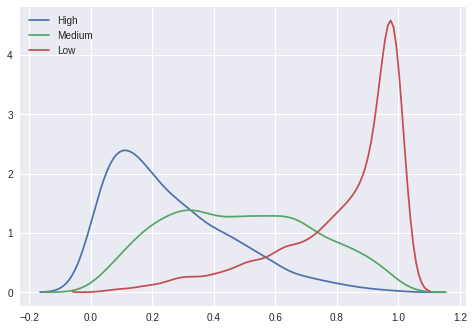

[0.54010489851593291]


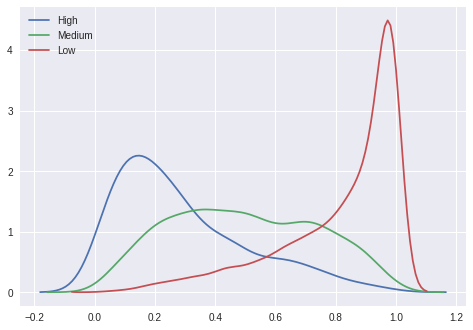

[0.54010489851593291, 0.55324089332725179]


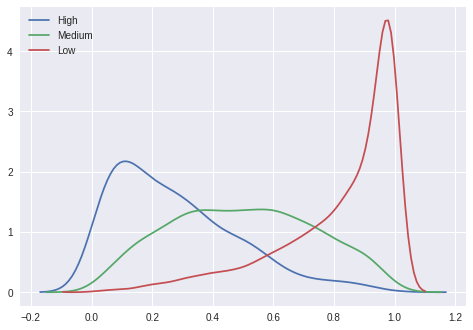

[0.54010489851593291, 0.55324089332725179, 0.54849470110770215]


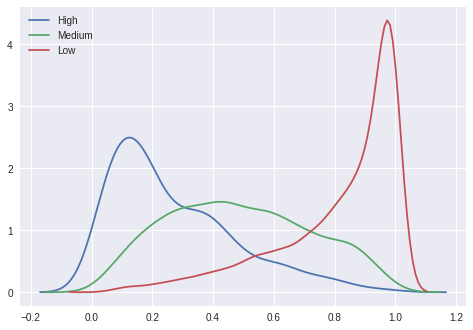

[0.54010489851593291, 0.55324089332725179, 0.54849470110770215, 0.54118048288476261]


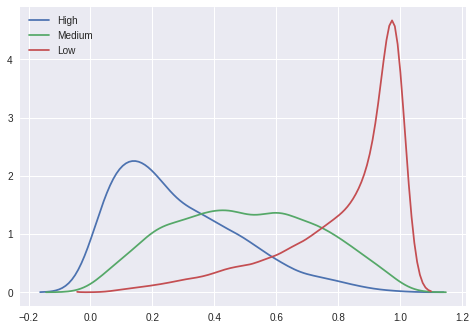

[0.54010489851593291, 0.55324089332725179, 0.54849470110770215, 0.54118048288476261, 0.53927755930553911]
mean score=0.544459707028


In [54]:
cv_scores = [] 
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(train_X,train_y):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
    #break
print 'mean score={}'.format(np.mean(cv_scores))

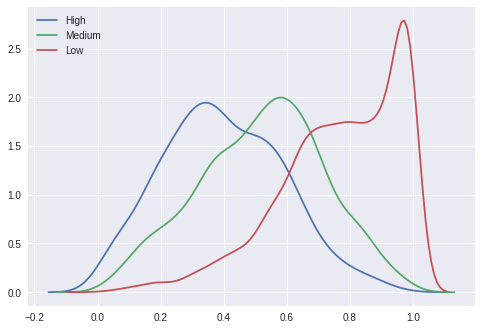

[0.6145644410714054]


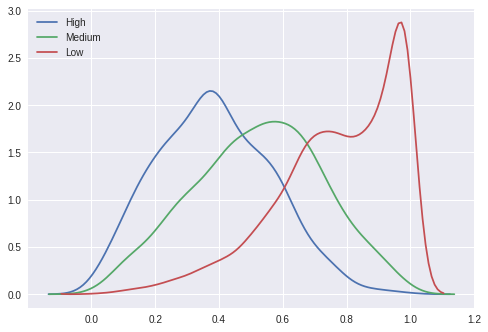

[0.6145644410714054, 0.63787676985808384]


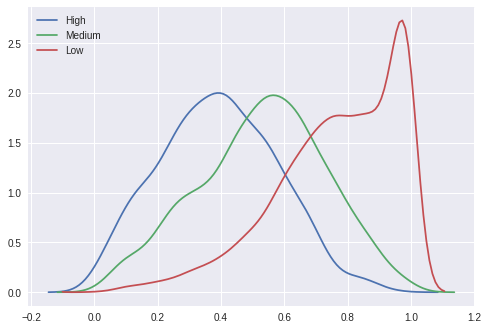

[0.6145644410714054, 0.63787676985808384, 0.64190732176939858]


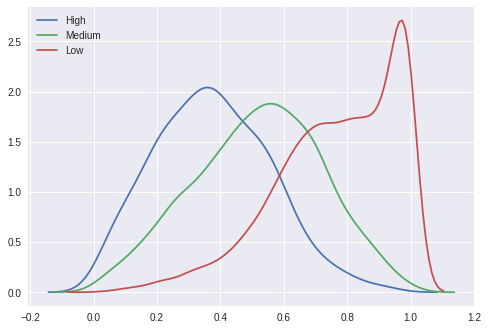

[0.6145644410714054, 0.63787676985808384, 0.64190732176939858, 0.64223018022216949]


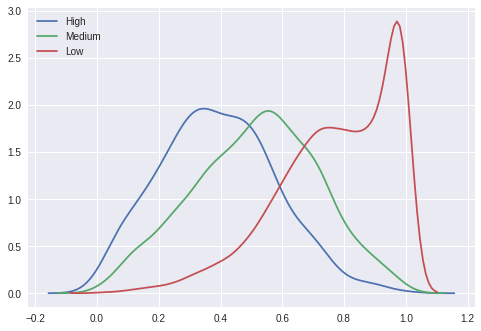

[0.6145644410714054, 0.63787676985808384, 0.64190732176939858, 0.64223018022216949, 0.61165725896277989]
mean score=0.629647194377


In [47]:
cv_scores = [] 
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runRF(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
    #break
print 'mean score={}'.format(np.mean(cv_scores))

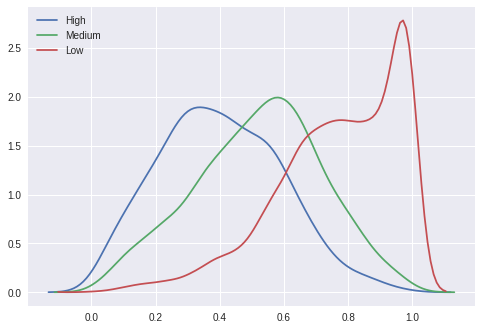

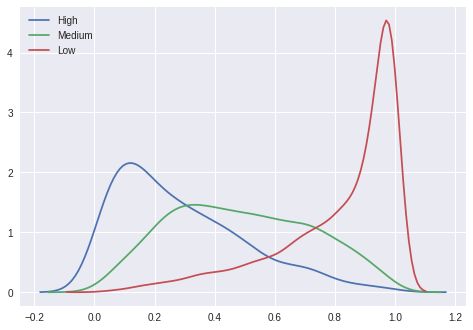

> <ipython-input-50-c3987f6c61c5>(12)<module>()
-> print pred_rf.shape
(Pdb) pred_rf.shape
(9871, 3)
(Pdb) tmp = np.hstack([pred_rf,preds])
(Pdb) tmp.shape
(9871, 6)
(Pdb) tmp.mean()
0.33333333330827669
(Pdb) tmp.mean(axis=0)
array([ 0.08276061,  0.23467582,  0.68256357,  0.07221964,  0.22645589,
        0.70132447])
(Pdb) tmp = tmp - tmp.mean()
(Pdb) tmp.shape
(9871, 6)
(Pdb) np.dot(tmp.T,tmp)/tmp.shape[0]
array([[ 0.07498507,  0.03079115, -0.10577622,  0.07743392,  0.03549606,
        -0.11292997],
       [ 0.03079115,  0.03992386, -0.07071501,  0.03310463,  0.03872919,
        -0.07183382],
       [-0.10577622, -0.07071501,  0.17649123, -0.11053855, -0.07422524,
         0.18476379],
       [ 0.07743392,  0.03310463, -0.11053855,  0.08637858,  0.03755659,
        -0.12393517],
       [ 0.03549606,  0.03872919, -0.07422524,  0.03755659,  0.05145911,
        -0.0890157 ],
       [-0.11292997, -0.07183382,  0.18476379, -0.12393517, -0.0890157 ,
         0.21295087]])
(Pdb) np.corrcoef(

BdbQuit: 

In [50]:
cv_scores = [] 
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_rf = runRF(dev_X,dev_y,val_X,val_y)
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    #cv_scores.append(log_loss(val_y, preds))
    #print(cv_scores)
    #break
    import pdb;pdb.set_trace()
    print pred_rf.shape
print 'mean score={}'.format(np.mean(cv_scores))

In [91]:
#random encoding: catetory -- added created_day,hour,month
cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB_sklearn_rank(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0]	validation_0-:0.97628	validation_1-:0.973941
Multiple eval metrics have been passed: 'validation_1-' will be used for early stopping.

Will train until validation_1- hasn't improved in 50 rounds.
[1]	validation_0-:0.97857	validation_1-:0.975917
[2]	validation_0-:0.980348	validation_1-:0.977667
[3]	validation_0-:0.980641	validation_1-:0.977982
[4]	validation_0-:0.981571	validation_1-:0.978884
[5]	validation_0-:0.981279	validation_1-:0.978628
[6]	validation_0-:0.980884	validation_1-:0.978051
[7]	validation_0-:0.981628	validation_1-:0.978682
[8]	validation_0-:0.981752	validation_1-:0.978722
[9]	validation_0-:0.981755	validation_1-:0.978886
[10]	validation_0-:0.981541	validation_1-:0.97852
[11]	validation_0-:0.982047	validation_1-:0.979052
[12]	validation_0-:0.981784	validation_1-:0.978728
[13]	validation_0-:0.981868	validation_1-:0.979079
[14]	validation_0-:0.982171	validation_1-:0.979385
[15]	validation_0-:0.982514	validation_1-:0.979847
[16]	validation_0-:0.982582	validation_1-:0.97

AttributeError: 'XGBRegressor' object has no attribute 'predict_proba'

In [118]:
#random encoding: catetory -- added created_day,hour,month
cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.54500709705163941]
[0.54500709705163941, 0.54699745163776825]
[0.54500709705163941, 0.54699745163776825, 0.54966425284497211]
[0.54500709705163941, 0.54699745163776825, 0.54966425284497211, 0.540506561959475]
[0.54500709705163941, 0.54699745163776825, 0.54966425284497211, 0.540506561959475, 0.54009903349604693]
mean score=0.544454879398


In [87]:
#random encoding: catetory -- added created_day,hour,month
cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.54770209048115226]
[0.54770209048115226, 0.55067861923135841]
[0.54770209048115226, 0.55067861923135841, 0.5503184486738707]
[0.54770209048115226, 0.55067861923135841, 0.5503184486738707, 0.54019368862446604]
[0.54770209048115226, 0.55067861923135841, 0.5503184486738707, 0.54019368862446604, 0.53764847793432113]
mean score=0.545308264989


In [98]:
#random encoding: catetory -- added created_day,hour,month
cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB_sklearn(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
    break
print 'mean score={}'.format(np.mean(cv_scores))



[0]	validation_0-mlogloss:1.09544	validation_1-mlogloss:1.09549
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.09236	validation_1-mlogloss:1.09246
[2]	validation_0-mlogloss:1.08932	validation_1-mlogloss:1.08947
[3]	validation_0-mlogloss:1.08626	validation_1-mlogloss:1.08647
[4]	validation_0-mlogloss:1.0832	validation_1-mlogloss:1.08347
[5]	validation_0-mlogloss:1.08034	validation_1-mlogloss:1.08067
[6]	validation_0-mlogloss:1.07731	validation_1-mlogloss:1.0777
[7]	validation_0-mlogloss:1.07436	validation_1-mlogloss:1.07482
[8]	validation_0-mlogloss:1.07157	validation_1-mlogloss:1.07208
[9]	validation_0-mlogloss:1.06874	validation_1-mlogloss:1.0693
[10]	validation_0-mlogloss:1.06593	validation_1-mlogloss:1.06655
[11]	validation_0-mlogloss:1.06311	validation_1-mlogloss:1.06379
[12]	validation_0-mlogloss:1.06032	validation_1-mlogloss:1.06105
[

In [101]:
preds, model = runXGB_sklearn(train_X, train_y, test_X,num_rounds=7000)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_starter2.csv", index=False)

In [361]:
#random encoding: catetory -- added created_day,hour,month
cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.54770209048115226]
[0.54770209048115226, 0.55067861923135841]
[0.54770209048115226, 0.55067861923135841, 0.5503184486738707]
[0.54770209048115226, 0.55067861923135841, 0.5503184486738707, 0.54019368862446604]
[0.54770209048115226, 0.55067861923135841, 0.5503184486738707, 0.54019368862446604, 0.53764847793432113]
mean score=0.545308264989


In [340]:
#random encoding: catetory -- better than the simple label encoder
cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.54929089028258327]
[0.54929089028258327, 0.55180332506463581]
[0.54929089028258327, 0.55180332506463581, 0.55220374716768095]
[0.54929089028258327, 0.55180332506463581, 0.55220374716768095, 0.5455426406637659]
[0.54929089028258327, 0.55180332506463581, 0.55220374716768095, 0.5455426406637659, 0.54145319650265533]
mean score=0.548058759936


In [180]:
#random encoding: catetory -- better than the simple label encoder
cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.55406418914862077]
[0.55406418914862077, 0.55358207509614243]
[0.55406418914862077, 0.55358207509614243, 0.55900484202849399]
[0.55406418914862077, 0.55358207509614243, 0.55900484202849399, 0.54684055320200375]
[0.55406418914862077, 0.55358207509614243, 0.55900484202849399, 0.54684055320200375, 0.54778271706477832]
mean score=0.552254875308


In [156]:
#category encoding: simple catetory
cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.57769866148583515]
[0.57769866148583515, 0.57442614427085281]
[0.57769866148583515, 0.57442614427085281, 0.57873035338112955]
[0.57769866148583515, 0.57442614427085281, 0.57873035338112955, 0.57075315474774135]
[0.57769866148583515, 0.57442614427085281, 0.57873035338112955, 0.57075315474774135, 0.57395351155853269]
mean score=0.575112365089


In [167]:
# with tex_fea combining,nTop=100 + description
tr_sparse,te_sparse = tfidf_fea(train_df,test_df,col='description',max_features=300)
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.57382726779799642]
[0.57382726779799642, 0.57638324168337962]
[0.57382726779799642, 0.57638324168337962, 0.58023885008456755]
[0.57382726779799642, 0.57638324168337962, 0.58023885008456755, 0.56415113859452903]
[0.57382726779799642, 0.57638324168337962, 0.58023885008456755, 0.56415113859452903, 0.56500115593046496]
mean score=0.571920330818


In [108]:
# with tex_fea combining,nTop=80

cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.57955695831547049]
[0.57955695831547049, 0.57955875031005255]
[0.57955695831547049, 0.57955875031005255, 0.58350642893451488]
[0.57955695831547049, 0.57955875031005255, 0.58350642893451488, 0.57376571781043095]
[0.57955695831547049, 0.57955875031005255, 0.58350642893451488, 0.57376571781043095, 0.57504426591299773]
mean score=0.578286424257


In [88]:
# with tex_fea combining,nTop=100

cv_scores = [] 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.57692421079839107]
[0.57692421079839107, 0.5806123970323448]
[0.57692421079839107, 0.5806123970323448, 0.58600541360975522]
[0.57692421079839107, 0.5806123970323448, 0.58600541360975522, 0.57230741205149938]
[0.57692421079839107, 0.5806123970323448, 0.58600541360975522, 0.57230741205149938, 0.57457995477929669]
mean score=0.578085877654


In [62]:
cv_scores = [] # did not use tex_fea combining
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.57984876585169454]
[0.57984876585169454, 0.58040018251448022]
[0.57984876585169454, 0.58040018251448022, 0.5867287738229362]
[0.57984876585169454, 0.58040018251448022, 0.5867287738229362, 0.57446984811977897]
[0.57984876585169454, 0.58040018251448022, 0.5867287738229362, 0.57446984811977897, 0.57352449818160489]
mean score=0.578994413698


In [35]:
#use all the features
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

10                                                         
10000     Doorman Elevator Fitness_Center Cats_Allowed D...
100004    Laundry_In_Building Dishwasher Hardwood_Floors...
100007                               Hardwood_Floors No_Fee
100013                                              Pre-War
Name: features, dtype: object


In [38]:
#use all features
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
print 'mean score={}'.format(np.mean(cv_scores))

[0.5773701525089705]
[0.5773701525089705, 0.58194489428507956]
[0.5773701525089705, 0.58194489428507956, 0.5861420324958877]
[0.5773701525089705, 0.58194489428507956, 0.5861420324958877, 0.57296162393814443]
[0.5773701525089705, 0.58194489428507956, 0.5861420324958877, 0.57296162393814443, 0.57793953448873325]
mean score=0.579271647543


In [37]:
def test_columns(features_to_use):
    train_X = train_df[features_to_use].as_matrix()
    train_y = np.array(train_df['interest_level'].map({'low':0,'medium':1,'high':2}),dtype=int).ravel()

    cv_scores = []
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
    for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
    print 'mean score={}'.format(np.mean(cv_scores))

In [34]:
test_columns(features_to_use)

[0.62121037926074996]
[0.62121037926074996, 0.62287273476000105]
[0.62121037926074996, 0.62287273476000105, 0.6266328252853246]
[0.62121037926074996, 0.62287273476000105, 0.6266328252853246, 0.62049149218956723]
[0.62121037926074996, 0.62287273476000105, 0.6266328252853246, 0.62049149218956723, 0.62429418069822351]
mean score=0.623100322439


In [30]:
test_columns(["bathrooms", "bedrooms", "latitude", "longitude", "price","created_month"])

[0.64801706963572037]
[0.64801706963572037, 0.64706635226905462]
[0.64801706963572037, 0.64706635226905462, 0.65182047731220605]
[0.64801706963572037, 0.64706635226905462, 0.65182047731220605, 0.6451023465969572]
[0.64801706963572037, 0.64706635226905462, 0.65182047731220605, 0.6451023465969572, 0.65716076775960219]
mean score=0.649833402715


In [31]:
test_columns(["bathrooms", "bedrooms", "latitude", "longitude", "price"])

[0.64860031748125746]
[0.64860031748125746, 0.65035546226248397]
[0.64860031748125746, 0.65035546226248397, 0.6514421360583017]
[0.64860031748125746, 0.65035546226248397, 0.6514421360583017, 0.64662167041852892]
[0.64860031748125746, 0.65035546226248397, 0.6514421360583017, 0.64662167041852892, 0.65757608472228313]
mean score=0.650919134189


# explore the features column